<img style="float: center;" src="https://unit8.com/wp-content/uploads/2021/07/darts-logo2-01-scaled.jpg" width="210">

# **TL;DR:** 
   
    
📌 **<ins>Baseline</ins>**: 
    
* **Exponential Smoothing** applied to every single series generates a good baseline forecast - **RMSLE: 0.40578**
 <br />
    
📌 **<ins>Goal</ins>**: 

* Leverage the large amount of timeseries via **global models** with more complex, flexible methods **(Boosted Trees, Neural Networks)**
 <br />   
 
📌 **<ins>Deep Learning Models</ins>**: 

* This notebook implements the Neural Network models **N-HiTS, LSTM and TFT** from Pytorch via the TS library Darts
 <br />   
    
📌 **<ins>Best Model</ins>**: 
    
* **33 Global LightGBM Models**, one for every product family
* **Each trained on 54 timeseries** (for 54 stores)

🏆 ->   **RMSLE: 0.38558**  ->  #1 Leaderboard (21.09.2022), V24 of this notebook
    <br />  
    <br />  
    <br />  
    
    

## What's happening here?
   <br />

In this notebook, I try to test and learn different approaches towards using Machine Learning for Timeseries Forecasting. I want to present a comprehensive forecasting workflow. My main focus is on exploring Neural Network models (such as LSTM, NBEATS, TCN, TFT, N-HiTS).

My basic understanding is: such complex and flexible methods require a lot of data in order to perform well. With single, univariate timeseries, that's usually not the case, and statistical methods with more structure tend to perform better. Here however we have 1782 parallel and related timeseries - Sales data for 33 product categories in 54 stores.

Approaches I want to experiment with:

* **Global Models (trained on multiple timeseries)**
* **Hierarchical Forecasting (Forecast Reconciliation)**
* **Ensembling**
* **Combinations of all the above**

I use the **<ins>Darts Library</ins>** for my timeseries modeling - it simplifies the workflow a lot for a beginner-level programmer like me and has implementations of all the newest Deep Learning Forecasting methods around.

So far however, the simple Exponential Smoothing baseline proved superior to my (global) Neural Network models. Global Models based on boosted trees however perform well - so far the best. But I'm sure there is still a lot of room for optimization.

*I spammed the leaderboard with many submissions, as I couldn't replicate my original LightGBM submission created on Google Colab - turns out I had one little error in my code here when creating the final submission file with zero forecasting. I cleaned up that error now, so everything should be reproducible.

<a id="1"></a> <br>
# 1. Libraries

I use the [**Darts library**](https://unit8co.github.io/darts/index.html) for all my modeling here. It is an excellent and intuitive option for forecasting in Python, especially with regards to NN models. The developing team is very helpful and answering questions in their public communication channels, so I can highly recommend the library for timeseries forecasting!

In [1]:
# DARTS Library for Forecasting

#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

!pip install pyyaml==5.4.1
!pip install darts
import darts
print(darts.__version__)

!pip install -U optuna==2.0.0

#!pip install --upgrade numpy
import numpy as np
import time

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import LightGBMModel, CatBoostModel, Prophet, RNNModel, TFTModel, NaiveSeasonal, ExponentialSmoothing, NHiTSModel
from darts.metrics import mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
from darts.models import MovingAverage

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm import tqdm

import sklearn
from sklearn import preprocessing

import pandas as pd
import torch
import matplotlib.pyplot as plt
import gc

%matplotlib inline
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
flax 0.6.0 requires rich~=11.1, but you have rich 12.1.0 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.9/4

<a id="2"></a> <br>
# 2. Data

<a id="2.1."></a> <br>
# 2.1. Pre-Processing

After loading the data, I create **Darts-specific TimeSeries objects**. For the sales data, I generate so-called static covariates for each series (store number, product family, city, region, type and cluster). Those might be used by some models in Darts later on. I also create a set of time-based covariates like weekday, month and year. All covariate series get stacked together.

Furthermore, I scale all series between 0 and 1, and then apply a logarithmic transformation to them. I took this idea from [this helpful notebook](https://www.kaggle.com/code/carlmcbrideellis/store-sales-using-the-average-of-the-last-16-days). 

In [2]:
# Load all Datasets
df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
df_holidays_events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
df_transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
df_sample_submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')

# Sales Data (Target)

family_list = df_train['family'].unique()
family_list
store_list = df_stores['store_nbr'].unique()
store_list

train_merged = pd.merge(df_train, df_stores, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

df_test_dropped = df_test.drop(['onpromotion'], axis=1)
df_test_sorted = df_test_dropped.sort_values(by=['store_nbr','family'])

# Create TimeSeries objects (Darts) and arrange in a Dictionary clustered by Product Family

family_TS_dict = {}

for family in family_list:
  df_family = train_merged.loc[train_merged['family'] == family]

  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
                                static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
                                value_cols="sales", # target variable
                                fill_missing_dates=True,
                                freq='D')
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[family] = list_of_TS_family

# Transform the Sales Data

family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder") #OneHotEncoder would be better but takes longer
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
     
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  family_pipeline_dict[key] = train_pipeline
  family_TS_transformed_dict[key] = training_transformed

# Create TimeSeries objects (Darts) 1782

list_of_TS = TimeSeries.from_group_dataframe(
                                train_merged,
                                time_col="date",
                                group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
                                static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
                                value_cols="sales", # target variable
                                fill_missing_dates=True,
                                freq='D')
for ts in list_of_TS:
            ts = ts.astype(np.float32)

list_of_TS = sorted(list_of_TS, key=lambda ts: int(ts.static_covariates_values()[0,0]))

# Transform the Sales Data

train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder") #OneHotEncoder would be better but takes longer
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
     
training_transformed = train_pipeline.fit_transform(list_of_TS)

#train_merged.head()

# Create 7-day and 28-day moving average of sales

sales_moving_average_7 = MovingAverage(window=7)
sales_moving_average_28 = MovingAverage(window=28)

sales_moving_averages_dict = {}

for key in family_TS_transformed_dict:
  sales_mas_family = []
  
  for ts in family_TS_transformed_dict[key]:
    ma_7 = sales_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="sales_ma_7")
    ma_28 = sales_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="sales_ma_28")
    mas = ma_7.stack(ma_28)
    sales_mas_family.append(mas)
  
  sales_moving_averages_dict[key] = sales_mas_family  
    
# General Covariates (Time-Based and Oil)

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

# Time-Based Covariates

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

# Transform
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

#time_cov_transformed[-50:].plot()

# Oil Price

oil = TimeSeries.from_dataframe(df_oil, 
                                time_col = 'date', 
                                value_cols = ['dcoilwtico'],
                                freq = 'D')

oil = oil.astype(np.float32)

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverage(window=7)
oil_moving_average_28 = MovingAverage(window=28)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

# Stack General Covariates Together

general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

# Store-Specific Covariates (Transactions and Holidays)

# Transactions
df_transactions.sort_values(["store_nbr","date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
                                df_transactions,
                                time_col="date",
                                group_cols=["store_nbr"],  # individual time series are extracted by grouping `df` by `group_cols`
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())   # necessary workaround to remove static covariates (so I can stack covariates later on)
            series = series.astype(np.float32)
            transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

from datetime import datetime, timedelta

transactions_list_full = []

for ts in transactions_list:
  if ts.start_time() > pd.Timestamp('20130101'):
    end_time = (ts.start_time() - timedelta(days=1))
    delta = end_time - pd.Timestamp('20130101')
    zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'), 
                              end=end_time, freq="D"),
                              values=np.zeros(delta.days+1))
    ts = zero_series.append(ts)
    transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

# Moving Averages for Transactions
trans_moving_average_7 = MovingAverage(window=7)
trans_moving_average_28 = MovingAverage(window=28)

transactions_covs = []

for ts in transactions_transformed:
  ma_7 = trans_moving_average_7.filter(ts).astype(np.float32)
  ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="transactions_ma_7")
  ma_28 = trans_moving_average_28.filter(ts).astype(np.float32)
  ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="transactions_ma_28")
  trans_and_mas = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions").stack(ma_7).stack(ma_28)
  transactions_covs.append(trans_and_mas)



# Re-Defining Categories of Holidays in a Meaningful Way

df_holidays_events['type'] = np.where(df_holidays_events['transferred'] == True,'Transferred', 
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Transfer','Holiday', 
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Additional','Holiday', 
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Bridge','Holiday', 
                                      df_holidays_events['type'])


# Assign Holidays to all TimeSeries and Save in Dictionary

def holiday_list(df_stores):

    listofseries = []
    
    for i in range(0,len(df_stores)):
            
            df_holiday_dummies = pd.DataFrame(columns=['date'])
            df_holiday_dummies["date"] = df_holidays_events["date"]
            
            df_holiday_dummies["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & (df_holidays_events["locale"] == "National")), 1, 0)

            df_holiday_dummies["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)

            df_holiday_dummies["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)

            df_holiday_dummies["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)

            df_holiday_dummies["national_event"] = np.where(((df_holidays_events["type"] == "Event") & (df_holidays_events["locale"] == "National") & (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & (~df_holidays_events['description'].str.contains('futbol'))), 1, 0)

            df_holiday_dummies["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)

            df_holiday_dummies["local_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & ((df_holidays_events["locale_name"] == df_stores['state'][i]) | (df_holidays_events["locale_name"] == df_stores['city'][i]))), 1, 0)
                     
            listofseries.append(df_holiday_dummies)

    return listofseries

def remove_0_and_duplicates(holiday_list):

    listofseries = []
    
    for i in range(0,len(holiday_list)):
            
            df_holiday_per_store = list_of_holidays_per_store[i].set_index('date')

            df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]
            
            df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                                   'christmas':'max', 'football_event':'max', 
                                   'national_event':'max', 'work_day':'max', 
                                   'local_holiday':'max'}).reset_index()

            listofseries.append(df_holiday_per_store)

    return listofseries

def holiday_TS_list_54(holiday_list):

    listofseries = []
    
    for i in range(0,54):
            
            holidays_TS = TimeSeries.from_dataframe(list_of_holidays_per_store[i], 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
            holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
            holidays_TS = holidays_TS.astype(np.float32)
            listofseries.append(holidays_TS)

    return listofseries


list_of_holidays_per_store = holiday_list(df_stores)
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)   
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

# Stack Together Store-Specific Covariates with General Covariates

store_covariates_future = []

for store in range(0,len(store_list)):
  stacked_covariates = holidays_transformed[store].stack(general_covariates)  
  store_covariates_future.append(stacked_covariates)

store_covariates_past = []
holidays_transformed_sliced = holidays_transformed # for slicing past covariates

for store in range(0,len(store_list)):
  holidays_transformed_sliced[store] = holidays_transformed[store].slice_intersect(transactions_covs[store])
  general_covariates_sliced = general_covariates.slice_intersect(transactions_covs[store])
  stacked_covariates = transactions_covs[store].stack(holidays_transformed_sliced[store]).stack(general_covariates_sliced)  
  store_covariates_past.append(stacked_covariates)
    
# Store/Family-Varying Covariates (Promotion)

df_promotion = pd.concat([df_train, df_test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
df_promotion.tail()

family_promotion_dict = {}

for family in family_list:
  df_family = df_promotion.loc[df_promotion['family'] == family]

  list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
                                value_cols="onpromotion", # covariate of interest
                                fill_missing_dates=True,
                                freq='D')
  
  for ts in list_of_TS_promo:
            ts = ts.astype(np.float32)

  family_promotion_dict[family] = list_of_TS_promo

promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
  promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  promo_pipeline = Pipeline([promo_filler,
                             promo_scaler])
  
  promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

  # Moving Averages for Promotion Family Dictionaries
  promo_moving_average_7 = MovingAverage(window=7)
  promo_moving_average_28 = MovingAverage(window=28)

  promotion_covs = []

  for ts in promotion_transformed:
    ma_7 = promo_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
    ma_28 = promo_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
    promo_and_mas = ts.stack(ma_7).stack(ma_28)
    promotion_covs.append(promo_and_mas)

  promotion_transformed_dict[key] = promotion_covs

# 2.5. Assemble All Covariates in Dictionaries

past_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

  promotion_family = promotion_transformed_dict[key]
  sales_mas = sales_moving_averages_dict[key]
  covariates_past = [promotion_family[i].slice_intersect(store_covariates_past[i]).stack(store_covariates_past[i].stack(sales_mas[i])) for i in range(0,len(promotion_family))]

  past_covariates_dict[key] = covariates_past

future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

  promotion_family = promotion_transformed_dict[key]
  covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]

  future_covariates_dict[key] = covariates_future

only_past_covariates_dict = {}

for key in tqdm(sales_moving_averages_dict):
  sales_moving_averages = sales_moving_averages_dict[key]
  only_past_covariates = [sales_moving_averages[i].stack(transactions_covs[i]) for i in range(0,len(sales_moving_averages))]

  only_past_covariates_dict[key] = only_past_covariates

# Delete Original Dataframes to Save Memory

del(df_train)
del(df_test)
del(df_stores)
del(df_holidays_events)
del(df_oil)
del(df_transactions)
gc.collect()



100%|██████████| 33/33 [00:04<00:00,  8.08it/s]


19

<a id="2.2."></a> <br>
# 2.2. EDA

For a first impression, let's look at a few of the 1782 (store x product family) timeseries:

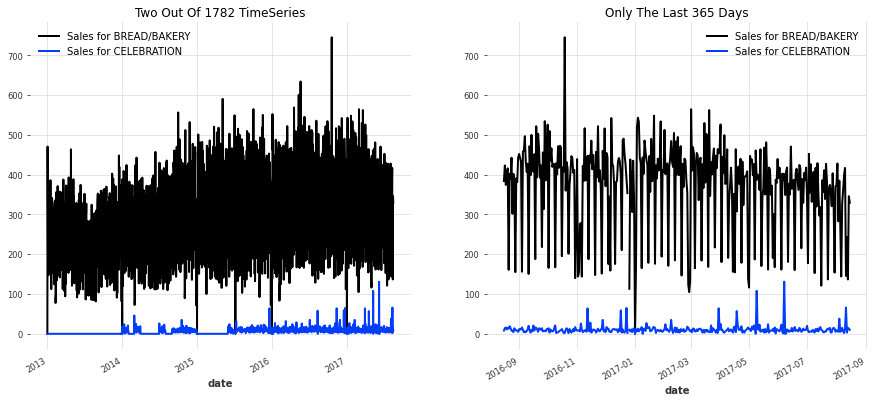

In [3]:
# Some EDA

bread_series = family_TS_dict['BREAD/BAKERY'][0]
celebration_series = family_TS_dict['CELEBRATION'][11]


# Let's print two of the 1782 TimeSeries

plt.subplots(2, 2, figsize=(15, 6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
bread_series.plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1], 
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

celebration_series.plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1], 
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]))

plt.title("Two Out Of 1782 TimeSeries")
           
plt.subplot(1, 2, 2) # index 2
bread_series[-365:].plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1], 
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

celebration_series[-365:].plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1], 
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]))

plt.title("Only The Last 365 Days")
plt.show()

Let's also plot the ACF for both series and investigate the seasonal patterns:

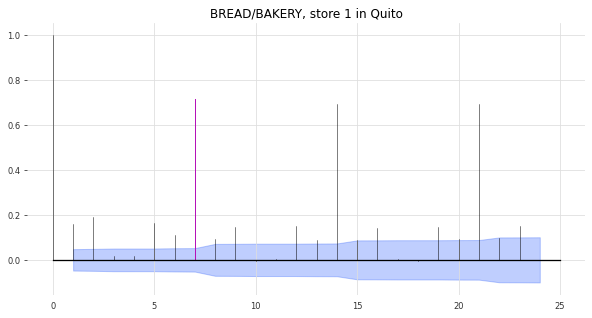

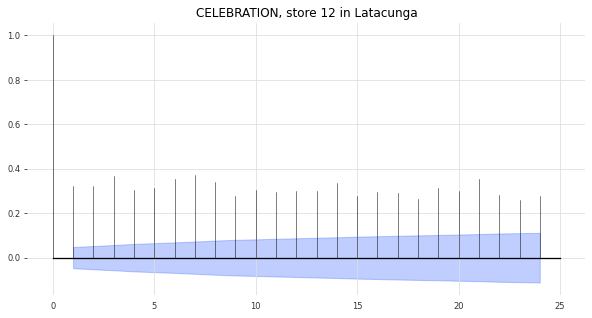

In [4]:
# Inspect Seasonality

plot_acf(fill_missing_values(bread_series), m=7, alpha=0.05)
plt.title("{}, store {} in {}".format(bread_series.static_covariates_values()[0,1], 
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

plot_acf(fill_missing_values(celebration_series), alpha=0.05)
plt.title("{}, store {} in {}".format(celebration_series.static_covariates_values()[0,1], 
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]));

As we can see, the BREAD/BAKERY series displays strong weekly seasonality, as we would expect. The CELEBRATION series however has a much less clear seasonal pattern. 

I encoded the static covariates and applied 0-1 Scaling + Log-Transformation to all series. Static covariates don't vary over time - examples in our dataset are the store number or region. Scaling is important for many of the deep learning models, and the logarithmic transformation of the training data will help against undershooting the actual sales with our forecasts.

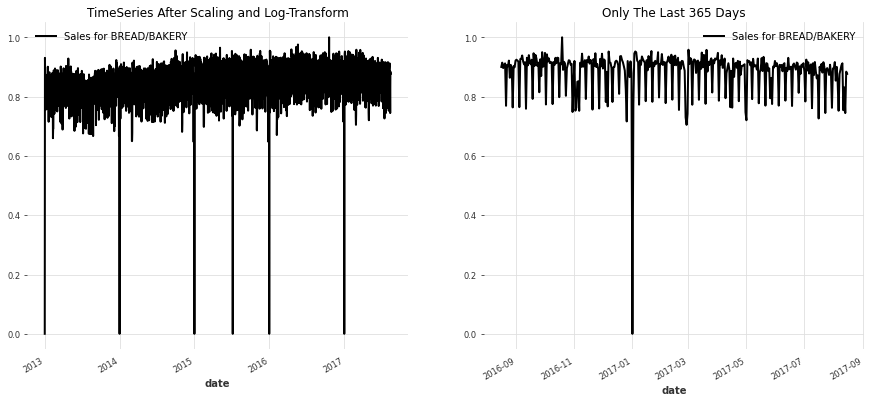

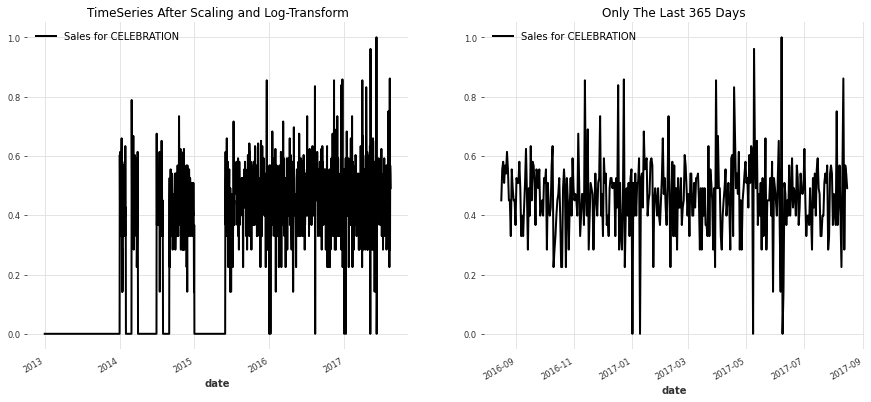

In [5]:
# Show the Differenced Series

# First Transform the Example Series
train_filler_bread = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
static_cov_transformer_bread = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder") 
log_transformer_bread = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler_bread = Scaler(verbose=False, n_jobs=-1, name="Scaling")

train_filler_celebration = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
static_cov_transformer_celebration = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder") 
log_transformer_celebration = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler_celebration = Scaler(verbose=False, n_jobs=-1, name="Scaling")

train_pipeline_bread = Pipeline([train_filler_bread,
                             static_cov_transformer_bread,
                             log_transformer_bread,
                             train_scaler_bread])

train_pipeline_celebration = Pipeline([train_filler_celebration,
                             static_cov_transformer_celebration,
                             log_transformer_celebration,
                             train_scaler_celebration])
     
bread_series_transformed = train_pipeline_bread.fit_transform(bread_series)
celebration_series_transformed = train_pipeline_celebration.fit_transform(celebration_series)

# Plots

plt.subplots(2, 2, figsize=(15, 6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
bread_series_transformed.plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1], 
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

plt.title("TimeSeries After Scaling and Log-Transform")
           
plt.subplot(1, 2, 2) # index 2
bread_series_transformed[-365:].plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1], 
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

plt.title("Only The Last 365 Days")
plt.show()

plt.subplots(2, 2, figsize=(15, 6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
celebration_series_transformed.plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1], 
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]))

plt.title("TimeSeries After Scaling and Log-Transform")
           
plt.subplot(1, 2, 2) # index 2
celebration_series_transformed[-365:].plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1], 
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]))

plt.title("Only The Last 365 Days")
plt.show()

## Covariates

Let's look at the covariates for the last 180 days of the BREAD/BAKERY series in store 1.

### Sales Moving Average Terms


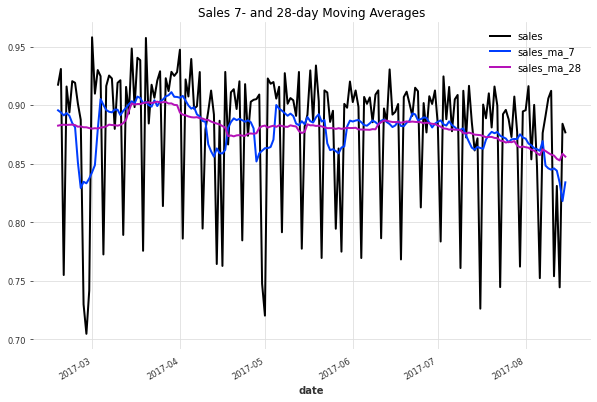

In [6]:
plt.figure(figsize=(10, 6))
family_TS_transformed_dict['BREAD/BAKERY'][0][-180:].plot()
sales_moving_averages_dict['BREAD/BAKERY'][0][-180:].plot()
plt.title("Sales 7- and 28-day Moving Averages");

### Promotion Data



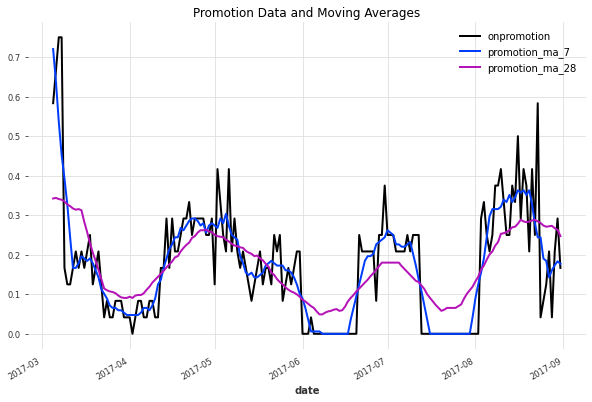

In [7]:
plt.figure(figsize=(10, 6))
promotion_transformed_dict['BREAD/BAKERY'][0][-180:].plot()
plt.title("Promotion Data and Moving Averages");

### Transactions

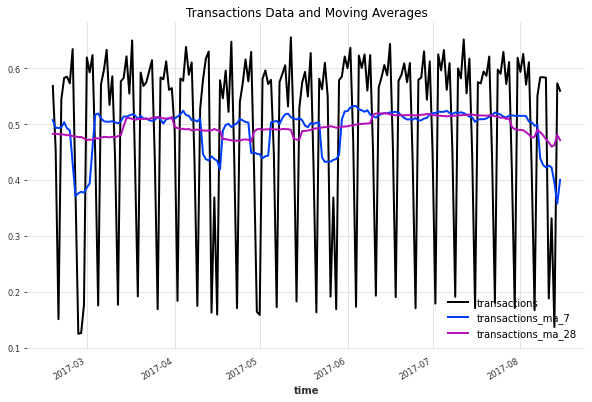

In [8]:
plt.figure(figsize=(10, 6))
transactions_covs[0][-180:].plot()
plt.title("Transactions Data and Moving Averages");

### Oil Price



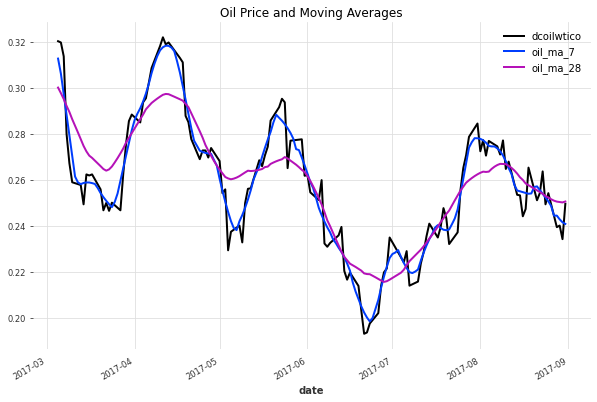

In [9]:
plt.figure(figsize=(10, 6))
oil_transformed[-180:].plot()
oil_moving_averages[-180:].plot()
plt.title("Oil Price and Moving Averages");

### Time Dummies and Covariates



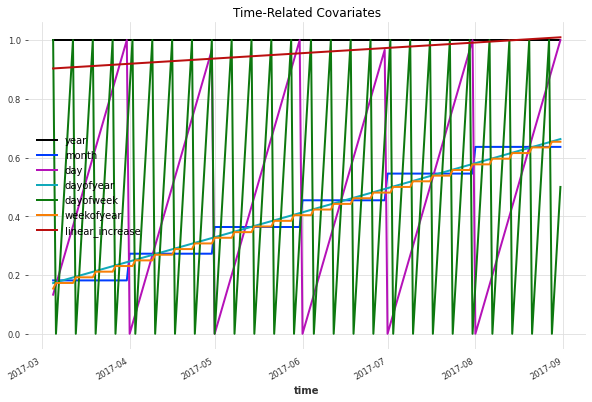

In [10]:
plt.figure(figsize=(10, 6))
time_cov_transformed[-180:].plot()
plt.title("Time-Related Covariates");

### Holidays and Events



I ordered the available data on holidays in the following seven categories. I think it might work better to generalize the categories further than what I did here.

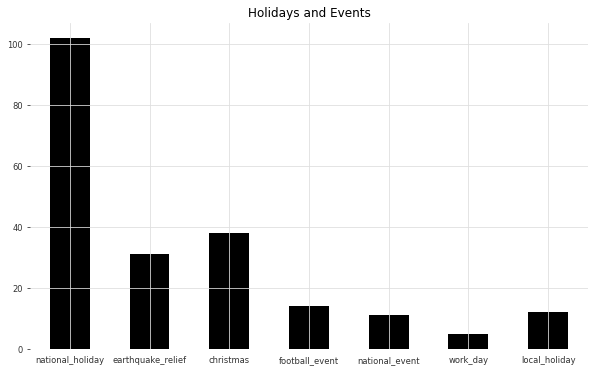

In [11]:
#df_holidays_events['type'].value_counts().plot.bar(rot=0)
plt.figure(figsize=(10, 6))
list_of_holidays_per_store[0].loc[:, list_of_holidays_per_store[0].columns != "date"].sum().plot.bar(rot=0)
plt.title("Holidays and Events");

<a id="3"></a> <br>
# 3. Simple Baseline Models

Before thinking about neural networks, I started by setting a baseline with traditional and more simple methods. The baseline forecast performance then constitutes a lower bound for the Machine Learning models' expected performance. I used three simple-to-implement models:

* Naive Seasonal Model (repeating the last 7 days)
* Exponential Smoothing
* Facebook Prophet

**Exponential Smoothing** gave the best results. For computational reasons, I commented out the other two models' training/evaluation later on.

<a id="3.1."></a> <br>
# 3.1. Some Quick Backtests

Let's quickly look at **backtests (historical forecasts)** for two individual series from our large dataset. We start with the sales for **Bread and Bakery in store 1** - one of the more consistent and seasonal series in our dataset.

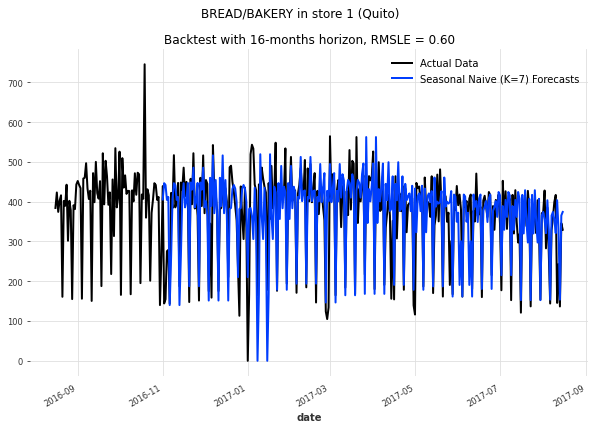

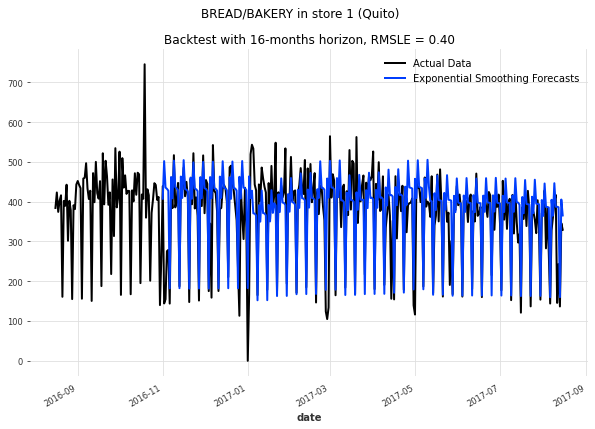

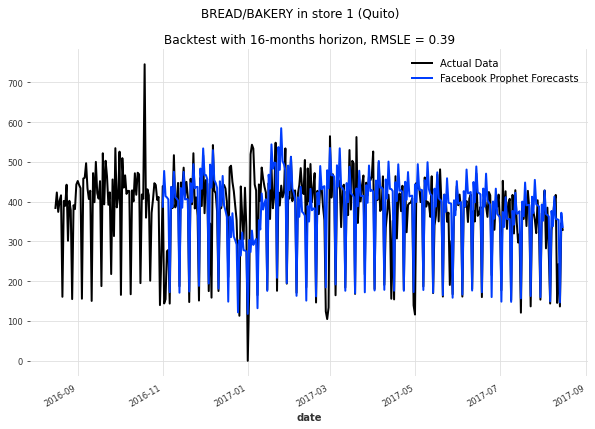

In [12]:
# Define Models

from darts.models import NaiveSeasonal, ExponentialSmoothing, Prophet
from darts.timeseries import concatenate
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

Naive_Seasonal_Model = NaiveSeasonal(K=7)

Exponential_Smoothing_Model = ExponentialSmoothing()

Prophet_Model = Prophet()

def eval_backtest(backtest_series, actual_series, horizon, transformer, model):
    actualdata = transformer.inverse_transform(actual_series, partial=True)
    forecasts = transformer.inverse_transform(backtest_series, partial=True)
    plt.figure(figsize=(10, 6))
    actualdata[-365:].plot(label="Actual Data")
    forecasts.plot(label=model)
    plt.legend()
    plt.suptitle("{} in store {} ({})".format(static_cov_transformer_bread.inverse_transform(actual_series).static_covariates_values()[0,1], 
                                                static_cov_transformer_bread.inverse_transform(actual_series).static_covariates_values()[0,0],
                                                static_cov_transformer_bread.inverse_transform(actual_series).static_covariates_values()[0,2]))
    plt.title("Backtest with {}-months horizon, RMSLE = {:.2f}".format(horizon,
            rmsle(actual_series=actualdata, pred_series=forecasts)))    
    
backtest_series_SN = Naive_Seasonal_Model.historical_forecasts(
    bread_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_ES = Exponential_Smoothing_Model.historical_forecasts(
    bread_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_Prophet = Prophet_Model.historical_forecasts(
    bread_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)


eval_backtest(
    backtest_series=concatenate(backtest_series_SN),
    actual_series=bread_series_transformed,
    horizon=16,
    transformer=train_pipeline_bread,
    model="Seasonal Naive (K=7) Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_ES),
    actual_series=bread_series_transformed,
    horizon=16,
    transformer=train_pipeline_bread,
    model="Exponential Smoothing Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_Prophet),
    actual_series=bread_series_transformed,
    horizon=16,
    transformer=train_pipeline_bread,
    model="Facebook Prophet Forecasts"
)

Except for the zero sales around christmas/new year 2017, the series follows a **very consistent pattern** - people eat bread every week. All three models are able to predict this pattern pretty well. The Seasonal Naive model however fails heavily in the aftermath of this one observed downward spike.

Let's now look at a **more complicated series** - as an example I picked the product family **CELEBRATION in store 19**. Though this series also has seasonal patterns, it displays much **more spikes**. How will our baseline models fare now?

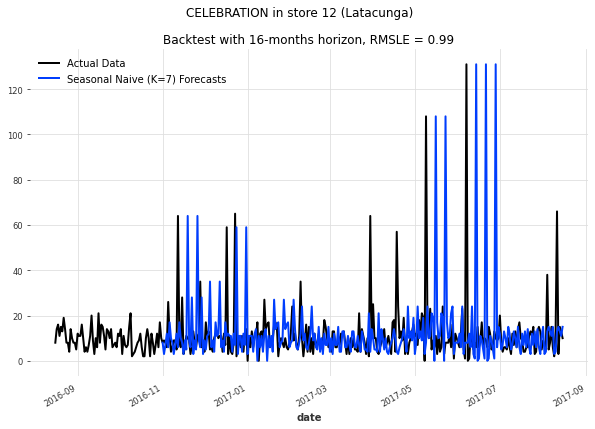

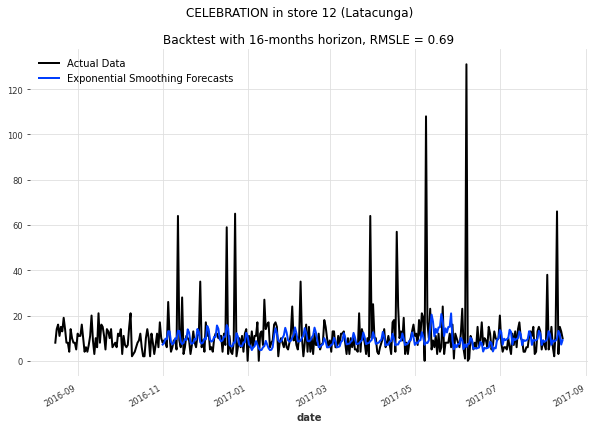

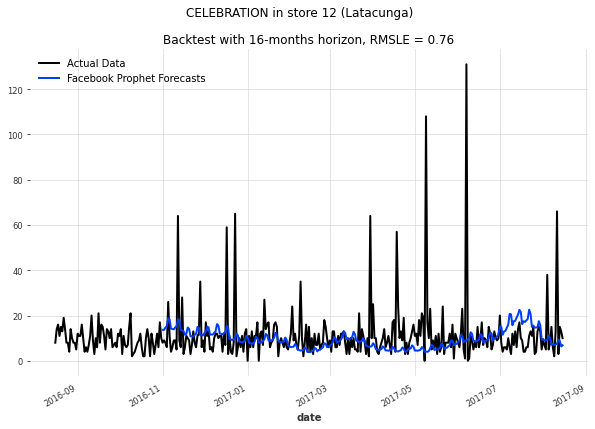

In [13]:
def eval_backtest(backtest_series, actual_series, horizon, transformer, model):
    actualdata = transformer.inverse_transform(actual_series, partial=True)
    forecasts = transformer.inverse_transform(backtest_series, partial=True)
    plt.figure(figsize=(10, 6))
    actualdata[-365:].plot(label="Actual Data")
    forecasts.plot(label=model)
    plt.legend()
    plt.suptitle("{} in store {} ({})".format(static_cov_transformer_celebration.inverse_transform(actual_series).static_covariates_values()[0,1], 
                                                static_cov_transformer_celebration.inverse_transform(actual_series).static_covariates_values()[0,0],
                                                static_cov_transformer_celebration.inverse_transform(actual_series).static_covariates_values()[0,2]))
    plt.title("Backtest with {}-months horizon, RMSLE = {:.2f}".format(horizon,
            rmsle(actual_series=actualdata, pred_series=forecasts)))    

backtest_series_SN_2 = Naive_Seasonal_Model.historical_forecasts(
    celebration_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_ES_2 = Exponential_Smoothing_Model.historical_forecasts(
    celebration_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_Prophet_2 = Prophet_Model.historical_forecasts(
    celebration_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)


eval_backtest(
    backtest_series=concatenate(backtest_series_SN_2),
    actual_series=celebration_series_transformed,
    horizon=16,
    transformer=train_pipeline_celebration,
    model="Seasonal Naive (K=7) Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_ES_2),
    actual_series=celebration_series_transformed,
    horizon=16,
    transformer=train_pipeline_celebration,
    model="Exponential Smoothing Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_Prophet_2),
    actual_series=celebration_series_transformed,
    horizon=16,
    transformer=train_pipeline_celebration,
    model="Facebook Prophet Forecasts"
)

Those forecasts are not ideal - predicting sales is not that easy after all. The spikes in "CELEBRATION" products are likely caused by special events. While the Seasonal Naive model generates many falsely predicted spikes (and misses most of the actual ones), the Exponential Smoothing and Prophet models capture underlying seasonal patterns and trends, but miss all spikes. Following those forecasts, our supermarkets would not carry enough celebration merchandise when it is demanded the most, missing a lot of profit.

From this little experiment, we can already see that good models must both capture the general seasonalities and trends in product sales, as well as understand predictable spikes and other special patterns. As we have data on holidays for example, that should hopefully be possible to some extent.

<a id="3.2."></a> <br>
# 3.2. Training/Test Split Performance Comparison

From now on, I will use a **simple training/test split** to evaluate models on all series - the forecast horizon will be **16 days** in order to mimic the leaderboard prediction task. While rolling window validation (as in the backtests before) is a more reliable approach, it would require too much computational resources during the experimental phase of the forecasting project. Once we start training neural network models, this will become obvious.

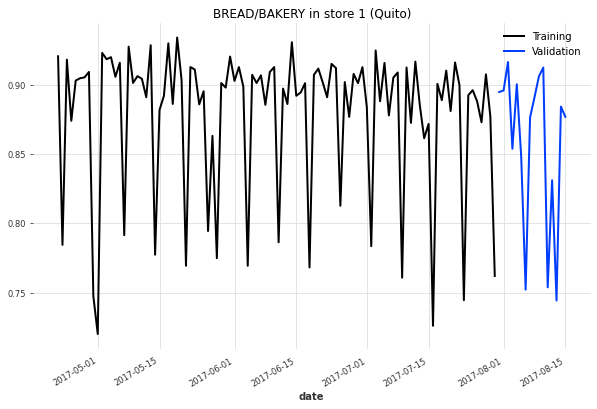

In [14]:
# Show example training and validation set for target series

training_series_bread = bread_series_transformed[:-16]
val_series_bread = bread_series_transformed[-16:]

plt.figure(figsize=(10, 6))
training_series_bread[-100:].plot(label='Training')
val_series_bread.plot(label='Validation')
plt.legend()
plt.title("{} in store {} ({})".format(bread_series.static_covariates_values()[0,1], 
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]));

For our baseline methods, we now train **1782 models, one for each (store x family) TimeSeries**. The forecasts created by these models will then be transformed back to the original scale. Additionally, we predict pure zero-forecasts for all series, which had no sales in the last two weeks (somewhat arbitrary choice).

In [15]:
# Functions for Exponential Smoothing Models and Forecasts

def ESModelBuilder(training_list):

    listofESmodels = []

    for i in range(0,len(training_list)):
        ES_model = ExponentialSmoothing()
        ES_model.fit(training_list[i])
        listofESmodels.append(ES_model)

    return listofESmodels 

def ESForecaster(model_list):

    listofESpreds = []

    for i in range(0,len(model_list)):
        pred_ES = model_list[i].predict(n=16)
        listofESpreds.append(pred_ES)        

    return listofESpreds 

# Train and Forecast with Exponential Smoothing Models

ES_Models_Family_Dict = {}
ES_Forecasts_Family_Dict = {}

# get the start time
st = time.time()

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]

  ES_Models_Family_Dict[family] = ESModelBuilder(training_data)
  forecasts_ES = ESForecaster(ES_Models_Family_Dict[family])
    
  # Transform Back
  ES_Forecasts_Family_Dict[family] = family_pipeline_dict[family].inverse_transform(forecasts_ES, partial=True)

  # Zero Forecasting
  for i in range(0,len(ES_Forecasts_Family_Dict[family])):
      if (training_data[i].univariate_values()[-14:] == 0).all():
          ES_Forecasts_Family_Dict[family][i] = ES_Forecasts_Family_Dict[family][i].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_exp = et - st
    

100%|██████████| 33/33 [10:53<00:00, 19.79s/it]


In [16]:
"""
# Functions for Exponential Smoothing Models and Forecasts

def NSModelBuilder(training_list):

    listofNSmodels = []

    for i in range(0,len(training_list)):
        NS_model = NaiveSeasonal(K=7)
        NS_model.fit(training_list[i])
        listofNSmodels.append(NS_model)

    return listofNSmodels 

def NSForecaster(model_list):

    listofNSpreds = []

    for i in range(0,len(model_list)):
        pred_NS = model_list[i].predict(n=16)
        listofNSpreds.append(pred_NS)        

    return listofNSpreds 

def ESModelBuilder(training_list):

    listofESmodels = []

    for i in range(0,len(training_list)):
        ES_model = ExponentialSmoothing()
        ES_model.fit(training_list[i])
        listofESmodels.append(ES_model)

    return listofESmodels 

def ESForecaster(model_list):

    listofESpreds = []

    for i in range(0,len(model_list)):
        pred_ES = model_list[i].predict(n=16)
        listofESpreds.append(pred_ES)        

    return listofESpreds 

def ProphetModelBuilder(training_list):

    listofPmodels = []

    for i in range(0,len(training_list)):
        P_model = Prophet()
        P_model.fit(training_list[i])
        listofPmodels.append(P_model)

    return listofPmodels 

def ProphetForecaster(model_list):

    listofPpreds = []

    for i in range(0,len(model_list)):
        pred_P = model_list[i].predict(n=16)
        listofPpreds.append(pred_P)        

    return listofPpreds 

# Train and Forecast with Exponential Smoothing Models

NS_Models_Family_Dict = {}
NS_Forecasts_Family_Dict = {}
ES_Models_Family_Dict = {}
ES_Forecasts_Family_Dict = {}
Prophet_Models_Family_Dict = {}
Prophet_Forecasts_Family_Dict = {}

import time
from multiprocessing import Pool

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]

  NS_Models_Family_Dict[family] = NSModelBuilder(training_data)
  forecasts_NS = NSForecaster(NS_Models_Family_Dict[family])
    
  # Transform Back
  NS_Forecasts_Family_Dict[family] = family_pipeline_dict[family].inverse_transform(forecasts_NS, partial=True)

  # Zero Forecasting
  for i in range(0,len(NS_Forecasts_Family_Dict[family])):
      if (training_data[i].univariate_values()[-21:] == 0).all():
          NS_Forecasts_Family_Dict[family][i] = NS_Forecasts_Family_Dict[family][i].map(lambda x: x * 0)
    
    
for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]

  ES_Models_Family_Dict[family] = ESModelBuilder(training_data)
  forecasts_ES = ESForecaster(ES_Models_Family_Dict[family])
    
  # Transform Back
  ES_Forecasts_Family_Dict[family] = family_pipeline_dict[family].inverse_transform(forecasts_ES, partial=True)

  # Zero Forecasting
  for i in range(0,len(ES_Forecasts_Family_Dict[family])):
      if (training_data[i].univariate_values()[-21:] == 0).all():
          ES_Forecasts_Family_Dict[family][i] = ES_Forecasts_Family_Dict[family][i].map(lambda x: x * 0)
    
 # commented out due to long computation

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]

  Prophet_Models_Family_Dict[family] = ProphetModelBuilder(training_data)
  forecasts_Prophet = ProphetForecaster(Prophet_Models_Family_Dict[family])
    
  # Transform Back
  Prophet_Forecasts_Family_Dict[family] = family_pipeline_dict[family].inverse_transform(forecasts_Prophet, partial=True)

  # Zero Forecasting
  for i in range(0,len(Prophet_Forecasts_Family_Dict[family])):
      if (training_data[i].univariate_values()[-21:] == 0).all():
          Prophet_Forecasts_Family_Dict[family][i] = Prophet_Forecasts_Family_Dict[family][i].map(lambda x: x * 0)
          """ 

'\n# Functions for Exponential Smoothing Models and Forecasts\n\ndef NSModelBuilder(training_list):\n\n    listofNSmodels = []\n\n    for i in range(0,len(training_list)):\n        NS_model = NaiveSeasonal(K=7)\n        NS_model.fit(training_list[i])\n        listofNSmodels.append(NS_model)\n\n    return listofNSmodels \n\ndef NSForecaster(model_list):\n\n    listofNSpreds = []\n\n    for i in range(0,len(model_list)):\n        pred_NS = model_list[i].predict(n=16)\n        listofNSpreds.append(pred_NS)        \n\n    return listofNSpreds \n\ndef ESModelBuilder(training_list):\n\n    listofESmodels = []\n\n    for i in range(0,len(training_list)):\n        ES_model = ExponentialSmoothing()\n        ES_model.fit(training_list[i])\n        listofESmodels.append(ES_model)\n\n    return listofESmodels \n\ndef ESForecaster(model_list):\n\n    listofESpreds = []\n\n    for i in range(0,len(model_list)):\n        pred_ES = model_list[i].predict(n=16)\n        listofESpreds.append(pred_ES)    

Let's check the RMSLE scores on the 16-days validation set we created:

In [17]:
# Re-Format Forecasts from Dictionaries to One List

forecast_list_ES = []

for family in family_list:
  forecast_list_ES.append(ES_Forecasts_Family_Dict[family])

sales_data = []

for family in family_list:
  sales_data.append(family_TS_dict[family])

# Function to Flatten Nested Lists
def flatten(l):
  return [item for sublist in l for item in sublist]
    
actual_list = flatten(sales_data)
pred_list_ES = flatten(forecast_list_ES)

# Mean RMSLE
ES_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_ES,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print("\n")
print("The mean RMSLE for the Local Exponential Smoothing Models over 1782 series is {:.5f}.".format(ES_rmsle))
print('Training & Inference duration:', elapsed_time_exp, 'seconds')
print("\n")



The mean RMSLE for the Local Exponential Smoothing Models over 1782 series is 0.37411.
Training & Inference duration: 653.0645875930786 seconds




In [18]:
"""

# Re-Format Forecasts from Dictionaries to One List

forecast_list_NS = []

for family in tqdm(family_list):
  forecast_list_NS.append(NS_Forecasts_Family_Dict[family])

forecast_list_ES = []

for family in tqdm(family_list):
  forecast_list_ES.append(ES_Forecasts_Family_Dict[family])

#forecast_list_Prophet = []

#for family in tqdm(family_list):
#  forecast_list_Prophet.append(Prophet_Forecasts_Family_Dict[family])

sales_data = []

for family in tqdm(family_list):
  sales_data.append(family_TS_dict[family])

# Function to Flatten Nested Lists
def flatten(l):
  return [item for sublist in l for item in sublist]
    
actual_list = flatten(sales_data)
pred_list_NS = flatten(forecast_list_NS)
pred_list_ES = flatten(forecast_list_ES)
#pred_list_Prophet = flatten(forecast_list_Prophet)
"""

"""
# Mean RMSLE

NS_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_NS,
                 n_jobs = -1,
                 inter_reduction=np.mean)

ES_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_ES,
                 n_jobs = -1,
                 inter_reduction=np.mean)

#Prophet_rmsle = rmsle(actual_series = actual_list,
#                 pred_series = pred_list_Prophet,
#                 n_jobs = -1,
#                 inter_reduction=np.mean)

print("The mean RMSLE for the Naive Seasonal (K=7) Model over all 1782 series is {:.5f}.".format(NS_rmsle))
print("\n")
print("The mean RMSLE for Exponential Smoothing over all 1782 series is {:.5f}.".format(ES_rmsle))
print("\n")
#print("The mean RMSLE for Prophet over all 1782 series is {:.5f}.".format(Prophet_rmsle))
"""

'\n# Mean RMSLE\n\nNS_rmsle = rmsle(actual_series = actual_list,\n                 pred_series = pred_list_NS,\n                 n_jobs = -1,\n                 inter_reduction=np.mean)\n\nES_rmsle = rmsle(actual_series = actual_list,\n                 pred_series = pred_list_ES,\n                 n_jobs = -1,\n                 inter_reduction=np.mean)\n\n#Prophet_rmsle = rmsle(actual_series = actual_list,\n#                 pred_series = pred_list_Prophet,\n#                 n_jobs = -1,\n#                 inter_reduction=np.mean)\n\nprint("The mean RMSLE for the Naive Seasonal (K=7) Model over all 1782 series is {:.5f}.".format(NS_rmsle))\nprint("\n")\nprint("The mean RMSLE for Exponential Smoothing over all 1782 series is {:.5f}.".format(ES_rmsle))\nprint("\n")\n#print("The mean RMSLE for Prophet over all 1782 series is {:.5f}.".format(Prophet_rmsle))\n'

**Exponential Smoothing achieves the smallest error (RMSLE = 0.37411) for our validation data!**

To further investigate those models' performance, let's print the **mean RMSLE for each product category**:

In [19]:
# Mean RMSLE for Families

family_forecast_rmsle_ES = {}

for family in family_list:

  ES_rmsle_family = rmsle(actual_series = family_TS_dict[family],
                 pred_series = ES_Forecasts_Family_Dict[family],
                 n_jobs = -1,
                 inter_reduction=np.mean)
  
  family_forecast_rmsle_ES[family] = ES_rmsle_family


family_forecast_rmsle_ES = dict(sorted(family_forecast_rmsle_ES.items(), key=lambda item: item[1]))

print("\n")
print("Mean RMSLE for the 33 different product families, from worst to best:")
print("\n")

# Iterate over key/value pairs in dict and print them
for key, value in family_forecast_rmsle_ES.items():
    print(key, ' : ', value)



Mean RMSLE for the 33 different product families, from worst to best:


BOOKS  :  0.02651197503458817
PRODUCE  :  0.16843766125266366
DAIRY  :  0.17848655145201983
BABY CARE  :  0.18114626716417453
BREAD/BAKERY  :  0.18897676415105819
DELI  :  0.2066933250933373
GROCERY I  :  0.2127276035335266
POULTRY  :  0.21482292812599496
MEATS  :  0.21491541089879915
BEVERAGES  :  0.2473325661277561
PREPARED FOODS  :  0.264123423522481
PERSONAL CARE  :  0.2664165041230439
HOME APPLIANCES  :  0.26717466516377136
EGGS  :  0.2776606798514665
FROZEN FOODS  :  0.2784342567353302
HOME CARE  :  0.3332755628285514
CLEANING  :  0.3497135935068673
LAWN AND GARDEN  :  0.3534249305533779
LIQUOR,WINE,BEER  :  0.42864824751226854
LADIESWEAR  :  0.44249147647648795
PLAYERS AND ELECTRONICS  :  0.4470152310152792
SEAFOOD  :  0.4648584971121303
PET SUPPLIES  :  0.46642742684488553
HOME AND KITCHEN II  :  0.47475863290616677
HOME AND KITCHEN I  :  0.49530259318248976
AUTOMOTIVE  :  0.5076609042415264
HARDWARE  :  

 I also plot the **three worst forecasts generated** - maybe we can learn something:

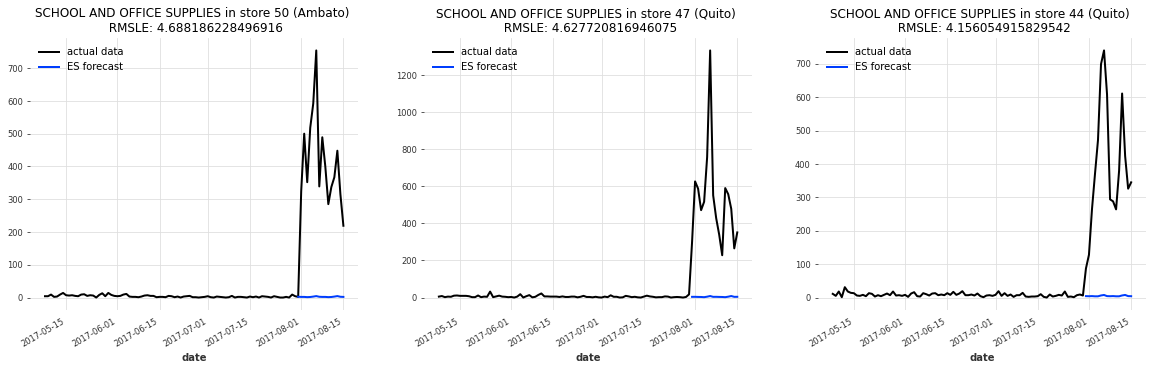

In [20]:
# Plot the five worst forecasts   #family_TS_dict

errorlist = []

for i in range(0, len(actual_list)):

  error = rmsle(actual_series = actual_list[i], 
                pred_series = pred_list_ES[i])
  
  errorfam = actual_list[i].static_covariates_values()[0,1]
  
  errorlist.append([errorfam,error])

rmsle_series_ES = pd.DataFrame(errorlist,columns=['family','RMSLE'])
worst_3_ES = rmsle_series_ES.sort_values(by=['RMSLE'], ascending=False).head(3)

fig,axs = plt.subplots(1,len(worst_3_ES),figsize=(20, 5))
labels = ["actual data", "ES forecast"]
for i in range(0, len(worst_3_ES)):
  plt_forecast = pred_list_ES[(worst_3_ES.index[i])]
  plt_actual = actual_list[(worst_3_ES.index[i])]
  plt_err = rmsle(plt_actual, plt_forecast)
  axis = axs[i]
  plt_actual[-100:].plot(ax=axis, label="actual data") #, label="actual data"
  plt_forecast.plot(ax=axis, label="ES forecast") #, label="ES forecast"
  axis.legend(loc="upper left")
  axis.title.set_text("{} in store {} ({}) \n RMSLE: {}".format(plt_forecast.static_covariates_values()[0,1], 
                                               plt_forecast.static_covariates_values()[0,0],
                                               plt_forecast.static_covariates_values()[0,2],
                                               plt_err))  

Apparently school has finally started;) Those forecasts are pretty bad, but the Exponential Smoothing models could not have been expected to predict a sudden peak in sales like this. My hope would be to capture such (in this case probably month/week-specific) patterns with more informed models using covariates, such as NN models.

<a id="4"></a> <br>
# 4. Global Modeling

Now that we set a solid baseline, can we improve our forecasts? My current understanding of timeseries forecasting is this:

When dealing with small datasets and few dimensions, fancy/complex models (I'm looking at you, neural networks) won't give much benefit, if any. I often found simpler statistical models outperforming them.

Intuitively, that makes sense: Neural networks are highly complex, non-linear models that don't force any structure on the data at hand. Statistical methods like ARIMA, Exponential Smoothing or Prophet on the other hand involve a lot of fixed structure and don't offer the same amount of flexibility as neural networks or boosted tree models. But when modeling a single univariate timeseries of a couple hundred data points, we don't need all this flexbility - there is not enough signal in our data to model highly complex relationships. When it comes to capturing basic patterns like seasonality and trend, statistical methods do a great job.

The store sales data at hand however consists of 1782 timeseries of considerable length, including a set of relevant covariates (such as holidays and product promotions). That means there should be some signal to exploit with Machine Learning models. I would expect (most of) those 1782 series to be somewhat similar/related to each other, as they all concern store sales, which should follow common patterns to some extent. So what now?

**Global Models!** My plan is to leverage the power of NN and Boosting models to exploit/capture as much of the signal in our huge dataset as possible. Whereas local models (like our Exponential Smoothing baseline) are trained on one timeseries, global models are trained on multiple series.

We will now look at three different deep learning models:

* LSTM (Long Short-Term Memory)
* N-HiTS (Neural Hierarchical Interpolation for TS Forecasting)
* TFT (Temporal Fusion Transformer)

The LSTM model (1995) has been around for some time, whereas TFT (2019) and N-HiTS (2022) are relatively new models. I chose these three neural network models for the different way the utilize covariates.

LSTM is a recurrent neural network (RNN) and expects covariates that extend into the future until the forecast horizon. Within the Darts framework, those are called *future_covariates*. N-HiTS is similar to the N-BEATS model, but might offer computational benefits over it. This model can only work take in *past_covariates*, known until the point in time when a forecast is generated. Last but not least, the TFT model supports both *past_covariates* and *future_covariates* as well as *static_covariates*.

Before training those models, I performed some hyperparameter tuning with the help of Python's Optuna library. As this can take quite some time for NN models, I let the tuning run with a quicker GPU on Google Colab. TFT seems to be the computationally heaviest out of those three NN models, while N-HiTS runs the quickest. For that reason, I will only include the Tuning for this model in my notebook.

### COMPUTATION ISSUES

Importantly, the following models are all trained with small subsets of the full timeseries (see the parameter *max_samples_per_ts* in the code) in order to make computation feasible. The Kaggle GPU is not quick enough to deal with bigger data I think. Therefore the following models should not be regarded as optimal at all, but rather serve as minimal examples.

CatBoost is trained with the last 365 samples (input + output lengths) of each series, N-HiTS is trained with the last 180 samples, LSTM is trained with the last 60 samples, and TFT is trained with only the last 7 samples per series. I chose those numbers to roughly equalize the training time for each of those models after experimenting a bit.

<a id="4.1"></a> <br>
# 4.1. N-HiTS


<img style="float: center;" src="https://images.deepai.org/converted-papers/2201.12886/x4.png">

*source*: https://images.deepai.org/converted-papers/2201.12886/x4.png

N-HiTS only supports *past_covariates*. As I still want to use the future-known information on promotion, holidays and time dummies, I shift back those covariates 16 days to the past. I define a function for training the model and then create an Optuna study, which I let run for 5 trials on the relatively slow Kaggle GPU. That is not a lot and will likely not deliver very good hyperparameters, but suffices as an example.

In [21]:
# Data Preparation for N-HiTS

def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])
    
future_covariates_full = flatten(future_covariates_full)

# Shift future covariates back so they can be used as past covariates

only_past_covariates = []

for family in family_list:
  only_past_covariates.append(only_past_covariates_dict[family])
    
only_past_covariates = flatten(only_past_covariates)

NHiTS_covariates = []

for i in range(0,len(future_covariates_full)):
  shifted = future_covariates_full[i].shift(n=-16)
  cut = shifted.slice_intersect(only_past_covariates[i])
  stacked = cut.stack(only_past_covariates[i])
  NHiTS_covariates.append(stacked)
    
# Split in train/val/test for Tuning and Validation

val_len = 16

train = [s[: -(2 * val_len)] for s in training_transformed]
val = [s[-(2 * val_len) : -val_len] for s in training_transformed]
test = [s[-val_len:] for s in training_transformed]

In [22]:
""" We write a function to build and fit a N-HiTS Model, which we will re-use later.
"""

def build_fit_nhits_model(
    input_chunk_length,
    num_stacks,
    num_blocks,
    num_layers,
    layer_exp,
    dropout,
    lr,
    likelihood=None,
    callbacks=None,
    #max_samples=None
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_N_EPOCHS = 50
    MAX_SAMPLES_PER_TS = 180

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.0001, patience=2, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": 1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
    
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the N-HiTS model
    model = NHiTSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=16,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2 ** layer_exp,
        dropout=dropout,
        n_epochs=MAX_N_EPOCHS,
        batch_size=128,
        add_encoders=None,
        likelihood=None, 
        loss_fn=torch.nn.MSELoss(),
        random_state=42,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="nhits_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + input_chunk_length) : -val_len] for s in training_transformed]


    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=NHiTS_covariates,
        val_past_covariates=NHiTS_covariates,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = NHiTSModel.load_from_checkpoint("nhits_model")

    return model

In [23]:
# Hyperparameter Tuning with Optuna

def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 21 and 365 days
    input_chunk_length = trial.suggest_int("input_chunk_length", 63, 270)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 3)
    num_blocks = trial.suggest_int("num_blocks", 1, 3)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    layer_exp = trial.suggest_int("layer_exp", 7, 10)
    #layer_widths = 2 ** layer_exp
    dropout = trial.suggest_float("dropout", 0.01, 0.2, step=0.01)
    lr = trial.suggest_float("lr", 5e-5, 0.1, log=True)

    # build and train the N-HiTS model with these hyper-parameters:
    model = build_fit_nhits_model(
                        input_chunk_length=input_chunk_length,
                        num_stacks=num_stacks,
                          num_blocks=num_blocks,
                        num_layers=num_layers,
                        layer_exp=layer_exp,
                          dropout=dropout,
                              lr=lr,
                          likelihood=None,
                          callbacks=callback,
                          #max_samples=365
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=train, past_covariates=NHiTS_covariates, n=val_len)
    rmsles = rmsle(val, preds, n_jobs=-1, verbose=True)
    rmsle_val = np.mean(rmsles)

    return rmsle_val if rmsle_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


torch.cuda.empty_cache()

study_nhits = optuna.create_study(direction="minimize")

study_nhits.optimize(objective, n_trials=5, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study_nhits.best_value}, Best params: {study_nhits.best_trial.params}")

[I 2022-11-17 01:53:07,429] A new study created in memory with name: no-name-5c2552b2-b320-4ff4-bfc9-d357fc0dfefc
/opt/conda/lib/python3.7/site-packages/torch/random.py:111: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  ).format(num_devices=num_devices, caller=_caller, devices_kw=_devices_kw))
/

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

[I 2022-11-17 02:09:37,702] Trial 0 finished with value: 0.06768599688497698 and parameters: {'input_chunk_length': 181, 'num_stacks': 1, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 9, 'dropout': 0.14, 'lr': 0.010078784588065512}. Best is trial 0 with value: 0.06768599688497698.


Current value: 0.06768599688497698, Current params: {'input_chunk_length': 181, 'num_stacks': 1, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 9, 'dropout': 0.14, 'lr': 0.010078784588065512}
Best value: 0.06768599688497698, Best params: {'input_chunk_length': 181, 'num_stacks': 1, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 9, 'dropout': 0.14, 'lr': 0.010078784588065512}


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:286: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

[I 2022-11-17 02:30:14,519] Trial 1 finished with value: 0.07773928345327351 and parameters: {'input_chunk_length': 190, 'num_stacks': 3, 'num_blocks': 1, 'num_layers': 3, 'layer_exp': 8, 'dropout': 0.13, 'lr': 0.004889729367858116}. Best is trial 0 with value: 0.06768599688497698.


Current value: 0.07773928345327351, Current params: {'input_chunk_length': 190, 'num_stacks': 3, 'num_blocks': 1, 'num_layers': 3, 'layer_exp': 8, 'dropout': 0.13, 'lr': 0.004889729367858116}
Best value: 0.06768599688497698, Best params: {'input_chunk_length': 181, 'num_stacks': 1, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 9, 'dropout': 0.14, 'lr': 0.010078784588065512}


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:286: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

[I 2022-11-17 02:58:50,845] Trial 2 finished with value: 0.06323797155681068 and parameters: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}. Best is trial 2 with value: 0.06323797155681068.


Current value: 0.06323797155681068, Current params: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}
Best value: 0.06323797155681068, Best params: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:286: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

[I 2022-11-17 03:15:41,498] Trial 3 finished with value: 0.10835513633253573 and parameters: {'input_chunk_length': 268, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 3, 'layer_exp': 10, 'dropout': 0.14, 'lr': 0.004136010167916462}. Best is trial 2 with value: 0.06323797155681068.


Current value: 0.10835513633253573, Current params: {'input_chunk_length': 268, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 3, 'layer_exp': 10, 'dropout': 0.14, 'lr': 0.004136010167916462}
Best value: 0.06323797155681068, Best params: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:286: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

[I 2022-11-17 03:42:26,509] Trial 4 finished with value: 0.1885274393627962 and parameters: {'input_chunk_length': 268, 'num_stacks': 1, 'num_blocks': 3, 'num_layers': 1, 'layer_exp': 10, 'dropout': 0.03, 'lr': 0.05155994337933316}. Best is trial 2 with value: 0.06323797155681068.


Current value: 0.1885274393627962, Current params: {'input_chunk_length': 268, 'num_stacks': 1, 'num_blocks': 3, 'num_layers': 1, 'layer_exp': 10, 'dropout': 0.03, 'lr': 0.05155994337933316}
Best value: 0.06323797155681068, Best params: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}
Best value: 0.06323797155681068, Best params: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}


So this are the best hyperparameters found:

In [24]:
# Finally, print the best value and best hyperparameters:
print(f"Best value: {study_nhits.best_value}, Best params: {study_nhits.best_trial.params}")

Best value: 0.06323797155681068, Best params: {'input_chunk_length': 266, 'num_stacks': 3, 'num_blocks': 3, 'num_layers': 2, 'layer_exp': 8, 'dropout': 0.01, 'lr': 0.002996870143374216}


Let's take a look at the Tuning process:

### Improvement of error score over Tuning trials

In [25]:
plot_optimization_history(study_nhits)


### Hyperparameter Importance over Tuning trials

In [26]:
plot_param_importances(study_nhits)

### Hyperparameter Search space and corresponding error scores

In [27]:
plot_contour(study_nhits, params=["lr", "num_stacks"])

Using the hyperparameters we got during this short Tuning session, we now train the N-HiTS model and make forecasts for the test set.

In [28]:
nhits_params = study_nhits.best_trial.params

# get the start time
st = time.time()

NHiTS_Model = build_fit_nhits_model(**nhits_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in training_transformed] 
preds = NHiTS_Model.predict(series=training_data, past_covariates=NHiTS_covariates, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)
        
# get the end time
et = time.time()

# get the execution time
elapsed_time_nhits = et - st

# Mean RMSLE

NHiTS_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)



/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.



Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:682: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [29]:
print("\n")
print("The mean RMSLE for the Global N-HiTS Model over 1782 series is {:.5f}.".format(NHiTS_rmsle))
print('Training & Inference duration:', elapsed_time_nhits, 'seconds')
print("\n")



The mean RMSLE for the Global N-HiTS Model over 1782 series is 0.43265.
Training & Inference duration: 1102.850519657135 seconds




<a id="4.1"></a> <br>
# 4.2. LSTM

<img style="float: center;" src="https://miro.medium.com/max/674/1*jikKbzFXCq-IYnFZankIMg.png">

*source*: https://miro.medium.com/max/674/1*jikKbzFXCq-IYnFZankIMg.png

LSTM only supports future-known covariates. In order to also utilize the data from our solely past-known covariates (sales and transactions data), I shift them forward 16 days into the future. While this approach might not be optimal, I found it to perform better than throwing out those covariates all-together.

A little Fine-Tuning gave me the following hyperparameters for LSTM:

* Input_chunk_length: 131 
* hidden_dim: 39 
* n_rnn_layers: 3
* learning rate: 0.0019971227090605087

Let's train this model with all our data and make a forecast for the 16 days test set!

In [30]:
# Data Preparation for LSTM

def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])
    
future_covariates_full = flatten(future_covariates_full)

# Shift past covariates forward so they can be used as future covariates


only_past_covariates = []

for family in family_list:
  only_past_covariates.append(only_past_covariates_dict[family])
    
only_past_covariates = flatten(only_past_covariates)


LSTM_covariates = []

for i in range(0,len(only_past_covariates)):
  shifted = only_past_covariates[i].shift(n=16)
  cut = future_covariates_full[i].slice_intersect(shifted)
  stacked = cut.stack(shifted)
  LSTM_covariates.append(stacked)
    
# Slice-Intersect target and covariates after shifting

LSTM_target = []

for i in range(0, len(training_transformed)):
  sliced = training_transformed[i].slice_intersect(LSTM_covariates[i])
  LSTM_target.append(sliced)

# Split in train/val/test for Tuning and Validation

val_len = 16

LSTM_train = [s[: -(2 * val_len)] for s in LSTM_target]
LSTM_val = [s[-(2 * val_len) : -val_len] for s in LSTM_target]
LSTM_test = [s[-val_len:] for s in LSTM_target]

In [31]:
""" We write a function to build and fit a TCN Model, which we will re-use later.
"""

def build_fit_lstm_model(
    input_chunk_length,
    hidden_dim,
    n_rnn_layers,
  #  dropout,
  #  training_length,
  #  batch_size,
  #  n_epochs,
    lr,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_N_EPOCHS = 100
    MAX_SAMPLES_PER_TS = 60

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.0001, patience=2, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": 1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the LSTM model
    model = RNNModel(
        model="LSTM",
        input_chunk_length=input_chunk_length,
        hidden_dim=hidden_dim,
        n_rnn_layers=n_rnn_layers,
        dropout=0,
        training_length=input_chunk_length + val_len -1,
        n_epochs=MAX_N_EPOCHS,
        batch_size=128,
        add_encoders=None,
        likelihood=None, 
        loss_fn=torch.nn.MSELoss(),
        random_state=42,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="lstm_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + input_chunk_length) : -val_len] for s in LSTM_target]


    # train the model
    model.fit(
        series=LSTM_train,
        val_series=model_val_set,
        future_covariates=LSTM_covariates,
        val_future_covariates=LSTM_covariates,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = RNNModel.load_from_checkpoint("lstm_model")

    return model

In [32]:
lstm_params = {'input_chunk_length': 131, 
               'hidden_dim': 39, 
               'n_rnn_layers': 3, 
               'lr': 0.0019971227090605087}

torch.cuda.empty_cache()

# get the start time
st = time.time()

LSTM_Model = build_fit_lstm_model(**lstm_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in LSTM_target] 
preds = LSTM_Model.predict(series=training_data, future_covariates=LSTM_covariates, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (LSTM_target[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)
        

# get the end time
et = time.time()

# get the execution time
elapsed_time_lstm = et - st

# Mean RMSLE

LSTM_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [33]:
print("\n")
print("The mean RMSLE for the Global LSTM Model over 1782 series is {:.5f}.".format(LSTM_rmsle))
print('Training & Inference duration:', elapsed_time_lstm, 'seconds')
print("\n")



The mean RMSLE for the Global LSTM Model over 1782 series is 0.55443.
Training & Inference duration: 1438.0281417369843 seconds




<a id="4.3"></a> <br>
# 4.3. TFT

<img style="float: center;" src="https://miro.medium.com/max/1400/1*7rXe_MVn5QI9oLP2vrMdvQ.png">

*source*: https://miro.medium.com/max/1400/1*7rXe_MVn5QI9oLP2vrMdvQ.png

The TFT model natively supports all types of covariates including static ones. It is however computationally very heavy.

I will use those hyperparameters:

* input_chunk_length: 230
* output_chunk_length: 16 
* hidden_size: 16 
* lstm_layers: 3 
* num_attention_heads: 4
* full_attention: True
* hidden_continuous_size: 16
* dropout: 0.060000000000000005
* lr: 0.009912733600616069



In [34]:
# Data Preparation for TFT

def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])
    
future_covariates_full = flatten(future_covariates_full)


only_past_covariates_full = []

for family in family_list:
  only_past_covariates_full.append(only_past_covariates_dict[family])
    
only_past_covariates_full = flatten(only_past_covariates_full)

# Split in train/val/test for Tuning and Validation

val_len = 16

train = [s[: -(2 * val_len)] for s in training_transformed]
val = [s[-(2 * val_len) : -val_len] for s in training_transformed]
test = [s[-val_len:] for s in training_transformed]

In [35]:
""" We write a function to build and fit a TCN Model, which we will re-use later.
"""


def build_fit_tft_model(
    input_chunk_length,
    output_chunk_length,
    hidden_size,
    lstm_layers,
    num_attention_heads,
    full_attention,
    #feed_forward,
    hidden_continuous_size,
    dropout,
    #batch_size,
    #add_relative_index,
    lr,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_N_EPOCHS = 100
    MAX_SAMPLES_PER_TS = 7

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.0001, patience=2, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": 1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the TFT model
    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention =full_attention,
        #feed_forward = feed_forward,
        hidden_continuous_size = hidden_continuous_size,
        dropout=dropout,
        batch_size=128,
        n_epochs=MAX_N_EPOCHS,
        #add_relative_index=add_relative_index,
        add_encoders=None,
        likelihood=None, 
        loss_fn=torch.nn.MSELoss(),
        random_state=42,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tft_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + input_chunk_length) : -val_len] for s in training_transformed]


    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_full,
        val_past_covariates=only_past_covariates_full,
        future_covariates=future_covariates_full,
        val_future_covariates=future_covariates_full,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = TFTModel.load_from_checkpoint("tft_model")

    return model

In [36]:
tft_params = {'input_chunk_length': 230, 
              'output_chunk_length': 16, 
              'hidden_size': 16, 
              'lstm_layers': 3, 
              'num_attention_heads': 4, 
              'full_attention': True, 
              'hidden_continuous_size': 16, 
              'dropout': 0.060000000000000005, 
              'lr': 0.009912733600616069}

torch.cuda.empty_cache()

# get the start time
st = time.time()

TFT_Model = build_fit_tft_model(**tft_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in training_transformed] 
preds = TFT_Model.predict(series=training_data, past_covariates=only_past_covariates_full, future_covariates=future_covariates_full, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_tft = et - st

# Mean RMSLE

TFT_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)



/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [37]:
print("\n")
print("The mean RMSLE for the Global TFT Model over 1782 series is {:.5f}.".format(TFT_rmsle))
print('Training & Inference duration:', elapsed_time_tft, 'seconds')
print("\n")



The mean RMSLE for the Global TFT Model over 1782 series is 0.43226.
Training & Inference duration: 1090.5660014152527 seconds




<a id="4.4"></a> <br>
# 4.4. Boosted Trees

<img style="float: center;" src="https://avatars.mds.yandex.net/get-yablogs/47421/file_1548410151831/orig">

*source*: https://avatars.mds.yandex.net/get-yablogs/47421/file_1548410151831/orig

Even though my focus has been on deep learning models, I actually found boosted tree models to perform best for this forecasting problem so far. Darts offers implementations of LightGBM and CatBoost. 

Due to out-of-memory issues in the Kaggle kernel, I commented out the training of boosted trees for now. From former notebooks and training on Colab however I can tell that those models have given the best scores so far.

In [38]:
"""
def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])
    
future_covariates_full = flatten(future_covariates_full)


only_past_covariates_full = []

for family in family_list:
  only_past_covariates_full.append(only_past_covariates_dict[family])
    
only_past_covariates_full = flatten(only_past_covariates_full)


only_past_covariates_shifted = []

for ts in only_past_covariates_full:
  shifted = ts.shift(n=16)
  only_past_covariates_shifted.append(shifted)

# Split in train/val/test for Tuning and Validation

val_len = 16

train = [s[: -(2 * val_len)] for s in training_transformed]
val = [s[-(2 * val_len) : -val_len] for s in training_transformed]
test = [s[-val_len:] for s in training_transformed]
"""

'\ndef flatten(l):\n  return [item for sublist in l for item in sublist]\n\nfuture_covariates_full = []\n\nfor family in family_list:\n  future_covariates_full.append(future_covariates_dict[family])\n    \nfuture_covariates_full = flatten(future_covariates_full)\n\n\nonly_past_covariates_full = []\n\nfor family in family_list:\n  only_past_covariates_full.append(only_past_covariates_dict[family])\n    \nonly_past_covariates_full = flatten(only_past_covariates_full)\n\n\nonly_past_covariates_shifted = []\n\nfor ts in only_past_covariates_full:\n  shifted = ts.shift(n=16)\n  only_past_covariates_shifted.append(shifted)\n\n# Split in train/val/test for Tuning and Validation\n\nval_len = 16\n\ntrain = [s[: -(2 * val_len)] for s in training_transformed]\nval = [s[-(2 * val_len) : -val_len] for s in training_transformed]\ntest = [s[-val_len:] for s in training_transformed]\n'

In [39]:
""" We write a function to build and fit a TCN Model, which we will re-use later.

from darts.models import CatBoostModel

def build_fit_cboost_model(
    lags,
    firstlag,
    pastcovlag,
    out_len,
    learning_rate,
    depth
    ):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_SAMPLES_PER_TS = 365

    # build the TCN model
    model = CatBoostModel(lags = lags,
                             lags_future_covariates = (firstlag,1),
                             lags_past_covariates = [-pastcovlag], 
                             output_chunk_length=out_len,
                          learning_rate=learning_rate,
                          depth=depth,
                             early_stopping_rounds=10,
                             random_state=2022,
                          logging_level='Silent'
                          )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + lags) : -val_len] for s in training_transformed]

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_shifted,
        val_past_covariates=only_past_covariates_shifted,
        future_covariates=future_covariates_full,
        val_future_covariates=future_covariates_full,
        max_samples_per_ts=MAX_SAMPLES_PER_TS
    )

    # reload best model over course of training
    #model = LightGBMModel.load_from_checkpoint("lgbm_model")

    return model
"""

' We write a function to build and fit a TCN Model, which we will re-use later.\n\nfrom darts.models import CatBoostModel\n\ndef build_fit_cboost_model(\n    lags,\n    firstlag,\n    pastcovlag,\n    out_len,\n    learning_rate,\n    depth\n    ):\n\n    # reproducibility\n    torch.manual_seed(42)\n\n    # some fixed parameters that will be the same for all models\n    MAX_SAMPLES_PER_TS = 365\n\n    # build the TCN model\n    model = CatBoostModel(lags = lags,\n                             lags_future_covariates = (firstlag,1),\n                             lags_past_covariates = [-pastcovlag], \n                             output_chunk_length=out_len,\n                          learning_rate=learning_rate,\n                          depth=depth,\n                             early_stopping_rounds=10,\n                             random_state=2022,\n                          logging_level=\'Silent\'\n                          )\n\n    # when validating during training, we can use 

In [40]:
"""
catboost_params = {'lags': 144, 
                   'out_len': 3, 
                   'firstlag': 44, 
                   'pastcovlag': 60, 
                   'learning_rate': 0.06539829509538796, 
                   'depth': 9}

# get the start time
st = time.time()

CatBoost_Model = build_fit_cboost_model(**catboost_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in training_transformed] 
preds = CatBoost_Model.predict(series=training_data, past_covariates=only_past_covariates_shifted, future_covariates=future_covariates_full, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_cboost = et - st

# Mean RMSLE

CatBoost_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print("\n")
print("The mean RMSLE for the Global CatBoost Model over 1782 series is {:.5f}.".format(CatBoost_rmsle))
print('Training & Inference duration:', elapsed_time_cboost, 'seconds')
print("\n")

"""

'\ncatboost_params = {\'lags\': 144, \n                   \'out_len\': 3, \n                   \'firstlag\': 44, \n                   \'pastcovlag\': 60, \n                   \'learning_rate\': 0.06539829509538796, \n                   \'depth\': 9}\n\n# get the start time\nst = time.time()\n\nCatBoost_Model = build_fit_cboost_model(**catboost_params)\n\n# Generate Forecasts for the Test Data\ntraining_data = [ts[:-16] for ts in training_transformed] \npreds = CatBoost_Model.predict(series=training_data, past_covariates=only_past_covariates_shifted, future_covariates=future_covariates_full, n=val_len)\n\n# Transform Back\nforecasts_back = train_pipeline.inverse_transform(preds, partial=True)\n\n# Zero Forecasting\nfor n in range(0,len(forecasts_back)):\n  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():\n        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)\n\n# get the end time\net = time.time()\n\n# get the execution time\nelapsed_time_cboost = et - st\n\n#

In [41]:
""" We write a function to build and fit a CatBoost Model, which we will re-use later.
"""
"""
from darts.models import CatBoostModel

def build_fit_family_cboost_model(
    lags,
    firstlag,
    pastcovlag,
    out_len,
    ):

    # reproducibility
    torch.manual_seed(42)

    # build the CatBoost model
    model = CatBoostModel(lags = lags,
                             lags_future_covariates = (firstlag,1),
                             lags_past_covariates = [-pastcovlag], 
                             output_chunk_length=out_len,
                             early_stopping_rounds=10,
                             random_state=2022
                          )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + lags) : -val_len] for s in sales_family]

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_fam_shifted,
        val_past_covariates=only_past_covariates_fam_shifted,
        future_covariates=future_covariates_fam,
        val_future_covariates=future_covariates_fam
    )

    return model

# Train CatBoost Family Models

CatBoost_Models = {}

for family in tqdm(family_list):
    
  sales_family = family_TS_transformed_dict[family]
  future_covariates_fam = future_covariates_dict[family]
  only_past_covariates_fam = only_past_covariates_dict[family]
                                                       
  only_past_covariates_fam_shifted = []                                                      
  for ts in only_past_covariates_fam:
      shifted = ts.shift(n=16)
      only_past_covariates_fam_shifted.append(shifted)

  # Split in train/val/test
  val_len = 16
  train = [s[: -(2 * val_len)] for s in sales_family]

  CatBoost_Model = build_fit_family_cboost_model( lags = 365,
    firstlag = 28,
    pastcovlag = 14,
    out_len = 1)

  CatBoost_Models[family] = CatBoost_Model
  """

'\nfrom darts.models import CatBoostModel\n\ndef build_fit_family_cboost_model(\n    lags,\n    firstlag,\n    pastcovlag,\n    out_len,\n    ):\n\n    # reproducibility\n    torch.manual_seed(42)\n\n    # build the CatBoost model\n    model = CatBoostModel(lags = lags,\n                             lags_future_covariates = (firstlag,1),\n                             lags_past_covariates = [-pastcovlag], \n                             output_chunk_length=out_len,\n                             early_stopping_rounds=10,\n                             random_state=2022\n                          )\n\n    # when validating during training, we can use a slightly longer validation\n    # set which also contains the first input_chunk_length time steps\n    model_val_set = [s[-((2 * val_len) + lags) : -val_len] for s in sales_family]\n\n    # train the model\n    model.fit(\n        series=train,\n        val_series=model_val_set,\n        past_covariates=only_past_covariates_fam_shifted,\n    

In [42]:
"""
# Generate Forecasts for the Test Data

CatBoost_Forecasts_Families = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]
  future_covariates_fam = future_covariates_dict[family]
  only_past_covariates_fam = only_past_covariates_dict[family]
                                                       
  only_past_covariates_fam_shifted = []                                                      
  for ts in only_past_covariates_fam:
      shifted = ts.shift(n=16)
      only_past_covariates_fam_shifted.append(shifted)

  forecast_CatBoost = CatBoost_Models[family].predict(n=16,
                                         series=training_data,
                                         future_covariates=future_covariates_fam,
                                         past_covariates=only_past_covariates_fam_shifted
                                         )
  
  CatBoost_Forecasts_Families[family] = forecast_CatBoost

# Transform Back

CatBoost_Forecasts_Families_back = {}

for family in tqdm(family_list):

  CatBoost_Forecasts_Families_back[family] = family_pipeline_dict[family].inverse_transform(CatBoost_Forecasts_Families[family], partial=True)

# Zero Forecasting

for family in tqdm(CatBoost_Forecasts_Families_back):
  for n in range(0,len(CatBoost_Forecasts_Families_back[family])):
    if (family_TS_dict[family][n][:-16].univariate_values()[-14:] == 0).all():
        CatBoost_Forecasts_Families_back[family][n] = CatBoost_Forecasts_Families_back[family][n].map(lambda x: x * 0)
        """

'\n# Generate Forecasts for the Test Data\n\nCatBoost_Forecasts_Families = {}\n\nfor family in tqdm(family_list):\n\n  sales_family = family_TS_transformed_dict[family]\n  training_data = [ts[:-16] for ts in sales_family]\n  future_covariates_fam = future_covariates_dict[family]\n  only_past_covariates_fam = only_past_covariates_dict[family]\n                                                       \n  only_past_covariates_fam_shifted = []                                                      \n  for ts in only_past_covariates_fam:\n      shifted = ts.shift(n=16)\n      only_past_covariates_fam_shifted.append(shifted)\n\n  forecast_CatBoost = CatBoost_Models[family].predict(n=16,\n                                         series=training_data,\n                                         future_covariates=future_covariates_fam,\n                                         past_covariates=only_past_covariates_fam_shifted\n                                         )\n  \n  CatBoost_Forecasts_Famili

In [43]:
"""
# Re-Format all 1782 Forecasts in one List and Evaluate Performance

forecast_list_CatBoost = []

for family in family_list:
  forecast_list_CatBoost.append(CatBoost_Forecasts_Families_back[family])

sales_data = []

for family in family_list:
  sales_data.append(family_TS_dict[family])

def flatten(l):
  return [item for sublist in l for item in sublist]
    
actual_list = flatten(sales_data)
pred_list_CatBoost = flatten(forecast_list_CatBoost)

# Mean RMSLE

CatBoost_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_CatBoost,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print("\n")
print("The mean RMSLE for the 33 CatBoost Global Product Family Models over all 1782 series is {:.5f}.".format(CatBoost_rmsle))
print("\n")

# Mean RMSLE for Families

family_forecast_rmsle_CatBoost = {}

for family in family_list:

  CatBoost_rmsle_family = rmsle(actual_series = family_TS_dict[family],
                 pred_series = CatBoost_Forecasts_Families_back[family],
                 n_jobs = -1,
                 inter_reduction=np.mean)
  
  family_forecast_rmsle_CatBoost[family] = CatBoost_rmsle_family

family_forecast_rmsle_CatBoost = dict(sorted(family_forecast_rmsle_CatBoost.items(), key=lambda item: item[1]))

print("Mean RMSLE for the 33 different product families, from worst to best:")
print("\n")

# Iterate over key/value pairs in dict and print them
for key, value in family_forecast_rmsle_CatBoost.items():
    print(key, ' : ', value)
"""

'\n# Re-Format all 1782 Forecasts in one List and Evaluate Performance\n\nforecast_list_CatBoost = []\n\nfor family in family_list:\n  forecast_list_CatBoost.append(CatBoost_Forecasts_Families_back[family])\n\nsales_data = []\n\nfor family in family_list:\n  sales_data.append(family_TS_dict[family])\n\ndef flatten(l):\n  return [item for sublist in l for item in sublist]\n    \nactual_list = flatten(sales_data)\npred_list_CatBoost = flatten(forecast_list_CatBoost)\n\n# Mean RMSLE\n\nCatBoost_rmsle = rmsle(actual_series = actual_list,\n                 pred_series = pred_list_CatBoost,\n                 n_jobs = -1,\n                 inter_reduction=np.mean)\n\nprint("\n")\nprint("The mean RMSLE for the 33 CatBoost Global Product Family Models over all 1782 series is {:.5f}.".format(CatBoost_rmsle))\nprint("\n")\n\n# Mean RMSLE for Families\n\nfamily_forecast_rmsle_CatBoost = {}\n\nfor family in family_list:\n\n  CatBoost_rmsle_family = rmsle(actual_series = family_TS_dict[family],\n   

In [44]:
"""
# Plot the five worst forecasts   

errorlist = []

for i in range(0, len(actual_list)):

  error = rmsle(actual_series = actual_list[i], 
                pred_series = pred_list_CatBoost[i])
  
  errorfam = actual_list[i].static_covariates_values()[0,1]
  
  errorlist.append([errorfam,error])

rmsle_series_CatBoost = pd.DataFrame(errorlist,columns=['family','RMSLE'])
worst_3_CatBoost = rmsle_series_CatBoost.sort_values(by=['RMSLE'], ascending=False).head(3)

for i in range(0, len(worst_3_CatBoost)):
  plt_forecast = pred_list_CatBoost[(worst_3_CatBoost.index[i])]
  plt_actual = actual_list[(worst_3_CatBoost.index[i])]
  plt_err = rmsle(plt_actual, plt_forecast)

  plt.figure(figsize=(10, 6))
  plt_actual[-100:].plot(label="actual data")
  plt_forecast.plot(label="CatBoost forecast")
  plt.title("{} in store {} ({}) - RMSLE: {}".format(plt_forecast.static_covariates_values()[0,1], 
                                                plt_forecast.static_covariates_values()[0,0],
                                                plt_forecast.static_covariates_values()[0,2],
                                                plt_err))
"""

'\n# Plot the five worst forecasts   \n\nerrorlist = []\n\nfor i in range(0, len(actual_list)):\n\n  error = rmsle(actual_series = actual_list[i], \n                pred_series = pred_list_CatBoost[i])\n  \n  errorfam = actual_list[i].static_covariates_values()[0,1]\n  \n  errorlist.append([errorfam,error])\n\nrmsle_series_CatBoost = pd.DataFrame(errorlist,columns=[\'family\',\'RMSLE\'])\nworst_3_CatBoost = rmsle_series_CatBoost.sort_values(by=[\'RMSLE\'], ascending=False).head(3)\n\nfor i in range(0, len(worst_3_CatBoost)):\n  plt_forecast = pred_list_CatBoost[(worst_3_CatBoost.index[i])]\n  plt_actual = actual_list[(worst_3_CatBoost.index[i])]\n  plt_err = rmsle(plt_actual, plt_forecast)\n\n  plt.figure(figsize=(10, 6))\n  plt_actual[-100:].plot(label="actual data")\n  plt_forecast.plot(label="CatBoost forecast")\n  plt.title("{} in store {} ({}) - RMSLE: {}".format(plt_forecast.static_covariates_values()[0,1], \n                                                plt_forecast.static_cov

<a id="4.5"></a> <br>
# 4.5. Model Comparison

Let's quickly compare the performance of the models we trained in this notebook:

In [45]:
print("\n")
print("Mean RMSLE for Local Exponential Smoothing Models: {:.5f}.".format(ES_rmsle))
print('Training duration:', elapsed_time_exp, 'seconds')
print("\n")
print("\n")
print("Mean RMSLE for Global N-HiTS Model: {:.5f}.".format(NHiTS_rmsle))
print('Training duration:', elapsed_time_nhits, 'seconds')
print("\n")
print("\n")
print("Mean RMSLE for Global LSTM Model: {:.5f}.".format(LSTM_rmsle))
print('Training duration:', elapsed_time_lstm, 'seconds')
print("\n")
print("\n")
print("Mean RMSLE for Global TFT Model: {:.5f}.".format(TFT_rmsle))
print('Training duration:', elapsed_time_tft, 'seconds')
print("\n")
print("\n")
# print("Mean RMSLE for Global CatBoost Model{:.5f}.".format(CatBoost_rmsle))
# print('Training duration:', elapsed_time_cboost, 'seconds')
# print("\n")



Mean RMSLE for Local Exponential Smoothing Models: 0.37411.
Training duration: 653.0645875930786 seconds




Mean RMSLE for Global N-HiTS Model: 0.43265.
Training duration: 1102.850519657135 seconds




Mean RMSLE for Global LSTM Model: 0.55443.
Training duration: 1438.0281417369843 seconds




Mean RMSLE for Global TFT Model: 0.43226.
Training duration: 1090.5660014152527 seconds






But once again, those models are way from optimal, as they have not been trained with full data nor have their hyperparameters been tuned in a proper way, which requires a stronger machine (unless I coded the training process in a very inefficient way, then let me know please!).

**Important:** Out of those global models, only TFT "knows" which series is which. It uses static covariates which contain info about store and product family, which identifies each series. N-HiTS, LSTM and LightGBM/CatBoost are trained with samples from all 1782 series without having direct information on the store/family ID of each series. That means, those models treat all samples as coming from the same data generating process. Whether that is a good assumption? Not sure - maybe it would work better to train global models for every product family or even store. There is always a trade-off between having more data and having more similarity between individual series for global models. I'm very interested in that topic - please comment if you have any ideas!

<a id="4"></a> <br>
# 5. Submission on Leaderboard

Re-trained the baseline Exponential Smoothing models on full training data leads to a **public RMSLE Score of 0.40578** - that's good enough to scratch the Top 10%. 33 Global LightGBM Models (1 for each product family) achieved a #1 **Leaderboard Score of 0.38558** at the time of submission. Additionally I added the code for generating submission forecasts with CatBoost, but with one global CatBoost model per product family. Uncomment for using any of them.

In [46]:
"""
# Train Final Exponential Smoothing Models and Forecast for Submission

ES_Models_Family_Dict_Submission = {}
ES_Forecasts_Family_Dict_Submission = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family]

  ES_Models_Family_Dict_Submission[family] = ESModelBuilder(training_data)
  forecasts_ES = ESForecaster(ES_Models_Family_Dict_Submission[family])
    
  # Transform Back
  ES_Forecasts_Family_Dict_Submission[family] = family_pipeline_dict[family].inverse_transform(forecasts_ES, partial=True)

  # Zero Forecasting
  for i in range(0,len(ES_Forecasts_Family_Dict_Submission[family])):
      if (training_data[i].univariate_values()[-21:] == 0).all():
          ES_Forecasts_Family_Dict_Submission[family][i] = ES_Forecasts_Family_Dict_Submission[family][i].map(lambda x: x * 0)
    
    
# Prepare Submission in Correct Format

listofseries = []

for store in range(0,54):
  for family in tqdm(family_list):
      oneforecast = ES_Forecasts_Family_Dict_Submission[family][store].pd_dataframe()
      oneforecast.columns = ['fcast']
      listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries) 
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted
submission_kaggle.to_csv('submission.csv', index=False)

# Train 33 Global LightGBM Models with Full Data

from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
from lightgbm import early_stopping

LGBM_Models_Submission = {}

for family in tqdm(family_list):

  # Define Data for family
  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  LGBM_Model_Submission = LightGBMModel(lags = 63,
                             lags_future_covariates = (14,1),
                             lags_past_covariates = [-16,-17,-18,-19,-20,-21,-22],
                             output_chunk_length=1,
                             random_state=2022,
                         #    max_bin= [63],
                             gpu_use_dp= "false")
     
  LGBM_Model_Submission.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed,
                        verbose=True)

  LGBM_Models_Submission[family] = LGBM_Model_Submission
  
  # Generate Forecasts for Submission

LGBM_Forecasts_Families_Submission = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family]
  LGBM_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                         series=train_sliced,
                                         future_covariates=LGBM_covariates,
                                         past_covariates=transactions_transformed)
  
  LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

# Transform Back

LGBM_Forecasts_Families_back_Submission = {}

for family in tqdm(family_list):

  LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

# Zero Forecasting

for family in tqdm(LGBM_Forecasts_Families_back_Submission):
  for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
    if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
        LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)
        
# Prepare Submission in Correct Format

listofseries = []

for store in range(0,54):
  for family in tqdm(family_list):
      oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
      oneforecast.columns = ['fcast']
      listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries) 
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted
submission_kaggle.to_csv('submission.csv', index=False)
"""

'\n# Train Final Exponential Smoothing Models and Forecast for Submission\n\nES_Models_Family_Dict_Submission = {}\nES_Forecasts_Family_Dict_Submission = {}\n\nfor family in tqdm(family_list):\n\n  sales_family = family_TS_transformed_dict[family]\n  training_data = [ts for ts in sales_family]\n\n  ES_Models_Family_Dict_Submission[family] = ESModelBuilder(training_data)\n  forecasts_ES = ESForecaster(ES_Models_Family_Dict_Submission[family])\n    \n  # Transform Back\n  ES_Forecasts_Family_Dict_Submission[family] = family_pipeline_dict[family].inverse_transform(forecasts_ES, partial=True)\n\n  # Zero Forecasting\n  for i in range(0,len(ES_Forecasts_Family_Dict_Submission[family])):\n      if (training_data[i].univariate_values()[-21:] == 0).all():\n          ES_Forecasts_Family_Dict_Submission[family][i] = ES_Forecasts_Family_Dict_Submission[family][i].map(lambda x: x * 0)\n    \n    \n# Prepare Submission in Correct Format\n\nlistofseries = []\n\nfor store in range(0,54):\n  for famil

In [47]:
""" 
from darts.models import CatBoostModel

def build_fit_family_cboost_model(
    lags,
    firstlag,
    pastcovlag,
    out_len,
    ):

    # reproducibility
    torch.manual_seed(42)

    # build the CatBoost model
    model = CatBoostModel(lags = lags,
                             lags_future_covariates = (firstlag,1),
                             lags_past_covariates = [-pastcovlag], 
                             output_chunk_length=out_len,
                             learning_rate=learning_rate,
                             depth=depth,
                             early_stopping_rounds=10,
                             random_state=2022
                          )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-(val_len + lags) : ] for s in sales_family]

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_fam_shifted,
        val_past_covariates=only_past_covariates_fam_shifted,
        future_covariates=future_covariates_fam,
        val_future_covariates=future_covariates_fam
    )

    return model
    
# Train Submission Model

CatBoost_Models = {}

for family in tqdm(family_list):
    
  sales_family = family_TS_transformed_dict[family]
  future_covariates_fam = future_covariates_dict[family]
  only_past_covariates_fam = only_past_covariates_dict[family]
                                                       
  only_past_covariates_fam_shifted = []                                                      
  for ts in only_past_covariates_fam:
      shifted = ts.shift(n=16)
      only_past_covariates_fam_shifted.append(shifted)

  # Split in train/val/test
  val_len = 16
  train = [s[: -val_len] for s in sales_family]

  CatBoost_Model = build_fit_family_cboost_model( lags = 144,
    firstlag = 44,
    pastcovlag = 60,
    learning_rate = 0.06539829509538796,
    depth = 9,
    out_len = 3)

  CatBoost_Models[family] = CatBoost_Model
  
# Generate Forecasts for Submission

CatBoost_Forecasts_Families_Submission = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]
  future_covariates_fam = future_covariates_dict[family]
  only_past_covariates_fam = only_past_covariates_dict[family]
                                                       
  only_past_covariates_fam_shifted = []                                                      
  for ts in only_past_covariates_fam:
      shifted = ts.shift(n=16)
      only_past_covariates_fam_shifted.append(shifted)
                                                       
  forecast_CatBoost = CatBoost_Models[family].predict(n=16,
                                         series=training_data,
                                         future_covariates=future_covariates_fam,
                                         past_covariates=only_past_covariates_fam_shifted)
  
  CatBoost_Forecasts_Families_Submission[family] = forecast_CatBoost

# Transform Back

CatBoost_Forecasts_Families_back_Submission = {}

for family in tqdm(family_list):

  CatBoost_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(CatBoost_Forecasts_Families_Submission[family], partial=True)

# Zero Forecasting

for family in tqdm(CatBoost_Forecasts_Families_back_Submission):
  for n in range(0,len(CatBoost_Forecasts_Families_back_Submission[family])):
    if (family_TS_dict[family][n].univariate_values()[-14:] == 0).all():
        CatBoost_Forecasts_Families_back_Submission[family][n] = CatBoost_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)
        
# Prepare Submission in Correct Format

listofseries = []

for store in range(0,54):
  for family in tqdm(family_list):
      oneforecast = CatBoost_Forecasts_Families_back_Submission[family][store].pd_dataframe()
      oneforecast.columns = ['fcast']
      listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries) 
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted
submission_kaggle.to_csv('submission.csv', index=False)

"""

' \nfrom darts.models import CatBoostModel\n\ndef build_fit_family_cboost_model(\n    lags,\n    firstlag,\n    pastcovlag,\n    out_len,\n    ):\n\n    # reproducibility\n    torch.manual_seed(42)\n\n    # build the CatBoost model\n    model = CatBoostModel(lags = lags,\n                             lags_future_covariates = (firstlag,1),\n                             lags_past_covariates = [-pastcovlag], \n                             output_chunk_length=out_len,\n                             learning_rate=learning_rate,\n                             depth=depth,\n                             early_stopping_rounds=10,\n                             random_state=2022\n                          )\n\n    # when validating during training, we can use a slightly longer validation\n    # set which also contains the first input_chunk_length time steps\n    model_val_set = [s[-(val_len + lags) : ] for s in sales_family]\n\n    # train the model\n    model.fit(\n        series=train,\n        v